## To benchmark the convolutional network, we also train a KNN algorithm to see what accuracy we get on the traffic dataset.

## For 5 neighbors we get a mean cross val score roughly 0.82 and 0.78 for 10 neighbors. This makes sense because increasing the number of neighbors increases the variance in the model and lowers the bias. 

### Incidentally over 93% accuracy has been achieved using random forests. 

### A bunch of preprocessing (refer the MNIST and TRAFFIC on CNN notebook for details. Same steps)

In [56]:
# k-nearest neighbors classifier on Traffic dataset.
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [64]:
import os
PATH = os.getcwd()
n_channels = 3

# Next we implement the inception on the German traffic signs dataset.

traffic_root_path = os.path.join(PATH, 'GTSRB/Final_Training/Images')

traffic_classes = sorted([dirname for dirname in os.listdir(traffic_root_path)
                         if os.path.isdir(os.path.join(traffic_root_path, dirname))])
#traffic_classes


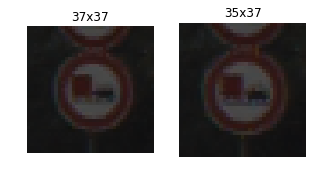

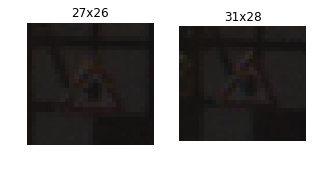

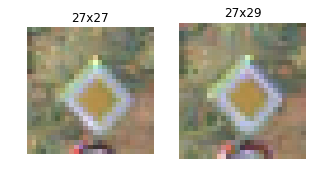

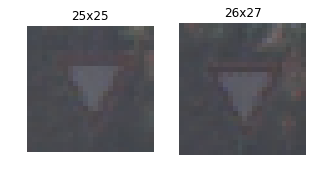

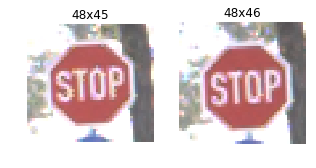

In [65]:
from collections import defaultdict

image_paths = defaultdict(list)
bounding_box_paths = defaultdict(list)

for traffic_signs in traffic_classes:
    image_dir = os.path.join(traffic_root_path, traffic_signs)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".ppm"):
            image_paths[traffic_signs].append(os.path.join(image_dir, filepath))

            
for traffic_signs in traffic_classes:
    image_dir = os.path.join(traffic_root_path, traffic_signs)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".csv"):
            bounding_box_paths[traffic_signs].append(os.path.join(image_dir, filepath))
            
# Next we see if we are getting the pictures we want. Image Paths is a dictionary and must be called as such.

import matplotlib.image as mpimg

images_per_class = 2

for traffic_class in traffic_classes[10:15]:
    plt.figure(figsize = (5, 5))
    for index, filename in enumerate(image_paths[traffic_class][:images_per_class]):
        my_image = mpimg.imread(filename)[:, :, :n_channels]
        plt.subplot(100 + images_per_class * 10 + index + 1)
        plt.title("{}x{}".format(my_image.shape[1], my_image.shape[0]))
        plt.imshow(my_image)
        plt.axis("off")
    plt.show()                                            



In [66]:
import pandas as pd

bound_box_array = []

for traffic in traffic_classes:
    for index, path in enumerate(bounding_box_paths[traffic]):
        myfile = pd.read_csv(path, sep = ";")
        bound_box_array.append([myfile["Roi.X1"], myfile["Roi.X2"], myfile["Roi.Y1"], myfile["Roi.Y2"]])    

In [67]:
traffic_class_paths = []

for traffic in traffic_classes:
    for index, path in enumerate(image_paths[traffic]):
        image_dir = os.path.join(traffic_root_path, traffic)
        traffic_class_paths.append((os.path.join(image_dir, path), traffic))
            

In [69]:
def center_image(image, traffic_label, index):
    x0 = bound_box_array[traffic_label][0][index]
    x1 = bound_box_array[traffic_label][1][index]
    y0 = bound_box_array[traffic_label][2][index]
    y1 = bound_box_array[traffic_label][3][index]
    
    return (imresize(image[x0:x1, y0:y1], (height, width)), traffic_label)

In [70]:
final_images = []
traffic_index = 0

for traffic in traffic_classes:
    for index, path in enumerate(image_paths[traffic], 0):
        input_image = mpimg.imread(path)
        final_images.append(center_image(input_image, traffic_index, index))
    traffic_index+=1        

In [71]:
np.random.seed(42)
from random import shuffle

shuffle(final_images)

In [72]:
train_val_split = 0.2
train_size = int(len(final_images)*(1-train_val_split))

train_set = final_images[:train_size]
val_set = final_images[train_size:]

print(len(train_set), len(val_set))
train_set[:1]

31367 7842


[(array([[[ 55,  32,   9],
          [ 56,  32,   9],
          [ 56,  32,   9],
          ..., 
          [ 82,  55,  23],
          [ 83,  55,  23],
          [ 84,  57,  24]],
  
         [[106,  78,  56],
          [106,  78,  56],
          [108,  79,  58],
          ..., 
          [ 97,  92,  68],
          [ 98,  93,  69],
          [ 98,  93,  68]],
  
         [[107,  98,  81],
          [107,  97,  81],
          [110,  99,  83],
          ..., 
          [ 70,  66,  66],
          [ 69,  65,  64],
          [ 69,  63,  63]],
  
         ..., 
         [[ 34,  26,  23],
          [ 34,  25,  22],
          [ 30,  25,  20],
          ..., 
          [ 54,  46,  40],
          [ 50,  40,  33],
          [ 40,  32,  26]],
  
         [[ 36,  29,  27],
          [ 34,  27,  25],
          [ 32,  25,  21],
          ..., 
          [ 82,  71,  55],
          [ 61,  48,  39],
          [ 43,  33,  30]],
  
         [[ 35,  28,  27],
          [ 32,  25,  23],
          [ 33,  27, 

In [82]:
X_val = [np.reshape(val_set[item][0], (height*width*n_channels))/np.float(255) for item in range(len(val_set))]
y_val = np.array([val_set[item][1] for item in range(len(val_set))], dtype = np.int32)

In [75]:
np.max(X_val[10])

0.32941176470588235

In [83]:
X_train = [np.reshape(train_set[item][0], (height*width*n_channels))/np.float(255) for item in range(len(train_set))]
y_train = np.array([train_set[item][1] for item in range(len(train_set))], dtype = np.int32)

In [77]:
# now we can run the k-nearest neighbors algorithm on the dataset. First we make sure data is zero meaned and pre-processed.
# we will use pipelines to run the algorithm.
np.max(X_train[10])

0.47450980392156861

In [85]:
# We also use k-fold cross validation to check results. 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)
X_train_scaled = scaler.fit_transform(X_train)

In [86]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

#### Run the KNN algorithm for 5 and 10 nearest neighbors to learn how increasing variance at expense of bias modifies the validation accuracy. 

In [87]:

n_neighbors = 5
rforest_clf = KNeighborsClassifier(n_neighbors = n_neighbors)
rforest_clf.fit(X_train_scaled, y_train)
y_scores = cross_val_score(rforest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


TypeError: cross_val_predict() got an unexpected keyword argument 'scoring'

In [88]:
y_scores

array([ 0.82790564,  0.82871079,  0.82231801])

In [93]:
n_neighbors = 10
rforest_clf = KNeighborsClassifier(n_neighbors = n_neighbors)
rforest_clf.fit(X_train_scaled, y_train)
y_scores_10 = cross_val_score(rforest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
y_predict_10 = cross_val_predict(rforest_clf, X_train_scaled, y_train, cv=3)

In [94]:
y_scores_10

array([ 0.78683984,  0.78615149,  0.78630268])

In [89]:
y_predict = cross_val_predict(rforest_clf, X_train_scaled, y_train, cv=3)

In [90]:
y_test_scores = rforest_clf.predict(X_val_scaled)

In [91]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_test_scores)

0.87503187962254525